# Example 4: 2nd-level Analysis

Last but not least, the 2nd-level analysis. After we removed left handed subjects and normalized all subject data into template space, we can now do the group analysis. To show the flexibility of Nipype, we will run the group analysis on data with two different smoothing kernel (``fwhm= [4, 8]``) and two different normalization (ANTs and SPM).

This example will also directly include thresholding of the output, as well as some visualization.

**Let's start!**

# Group Analysis with SPM

Let's first run the group analysis with the SPM normalized data.

## Imports (SPM12)

First, we need to import all modules we later want to use.

In [1]:
%matplotlib inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype.pipeline.engine import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

## Experiment parameters (SPM12)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [2]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005', 'con_0006', 'con_0007']

mask = "/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [3]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [4]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(output_dir, 'norm_spm', 'sub-*_fwhm{fwhm_id}',
                         'w{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'spm_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [5]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

170829-01:11:29,776 workflow INFO:
	 Generated workflow graph: /output/workingdir/spm_l2analysis/graph.dot.png (graph2use=colored, simple_form=True).


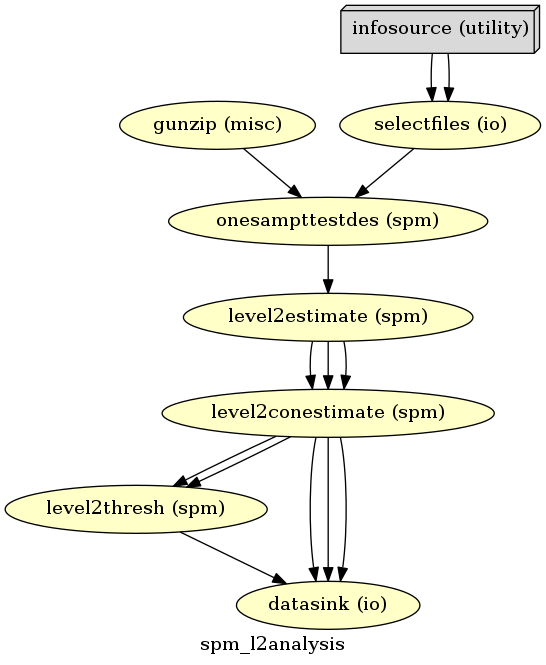

In [6]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.dot.png'))

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [7]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

170829-01:11:30,154 workflow INFO:
	 Workflow spm_l2analysis settings: ['check', 'execution', 'logging']
170829-01:11:30,326 workflow INFO:
	 Running in parallel.
170829-01:11:30,335 workflow INFO:
	 Executing: selectfiles.a13 ID: 0
170829-01:11:30,349 workflow INFO:
	 Executing: selectfiles.a12 ID: 1
170829-01:11:30,352 workflow INFO:
	 Executing node selectfiles.a13 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/selectfiles
170829-01:11:30,367 workflow INFO:
	 Executing: selectfiles.a11 ID: 2
170829-01:11:30,371 workflow INFO:
	 Executing node selectfiles.a12 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_4/selectfiles
170829-01:11:30,390 workflow INFO:
	 Executing: selectfiles.a10 ID: 3
170829-01:11:30,393 workflow INFO:
	 Executing node selectfiles.a11 in dir: /output/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_8/selectfiles
170829-01:11:30,413 workflow INFO:
	 Executing node selectfiles.a10 in dir: /output/workingdir/

# Group Analysis with ANTs

Now to run the same group analysis, but on the ANTs normalized images, we just need to change a few parameters:

In [8]:
# Change the SelectFiles template and recreate the node
templates = {'cons': opj(output_dir, 'norm_ants', 'sub-*_fwhm{fwhm_id}',
                         '{contrast_id}_trans.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Change the substituion parameters for the datasink
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'ants_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

Now, we just have to recreate the workflow.

In [9]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='ants_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

And we can run it!

In [10]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

170829-01:29:39,649 workflow INFO:
	 Workflow ants_l2analysis settings: ['check', 'execution', 'logging']
170829-01:29:39,971 workflow INFO:
	 Running in parallel.
170829-01:29:39,995 workflow INFO:
	 Executing: selectfiles.a13 ID: 0
170829-01:29:40,14 workflow INFO:
	 Executing: selectfiles.a12 ID: 1
170829-01:29:40,19 workflow INFO:
	 Executing node selectfiles.a13 in dir: /output/workingdir/ants_l2analysis/_contrast_id_con_0007_fwhm_id_8/selectfiles
170829-01:29:40,32 workflow INFO:
	 Executing: selectfiles.a11 ID: 2
170829-01:29:40,37 workflow INFO:
	 Executing node selectfiles.a12 in dir: /output/workingdir/ants_l2analysis/_contrast_id_con_0007_fwhm_id_4/selectfiles
170829-01:29:40,73 workflow INFO:
	 Executing: selectfiles.a10 ID: 3
170829-01:29:40,78 workflow INFO:
	 Executing node selectfiles.a11 in dir: /output/workingdir/ants_l2analysis/_contrast_id_con_0006_fwhm_id_8/selectfiles
170829-01:29:40,96 workflow INFO:
	 Executing node selectfiles.a10 in dir: /output/workingdir/ant

# Visualize results

Now we create a lot of outputs, but how do they look like? And also, what was the influence of different smoothing kernels and normalization?

**Keep in mind, that the group analysis was only done on *`N=7`* subjects, and that we chose a voxel-wise threshold of *`p<0.005`*. Nonetheless, we corrected for multiple comparisons with a cluster-wise FDR threshold of *`p<0.05`*.**

So let's first look at the contrast **average**:

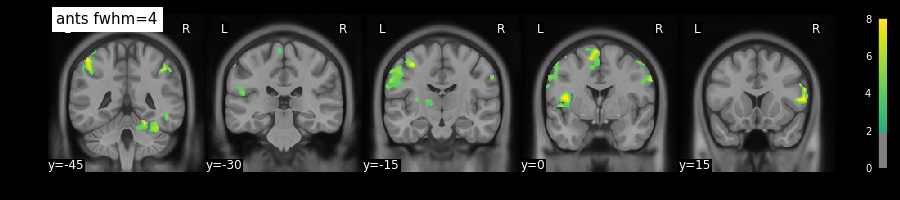

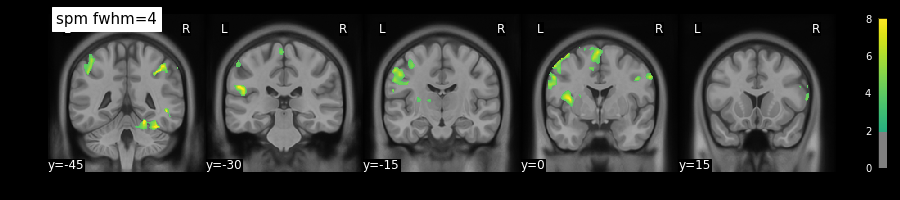

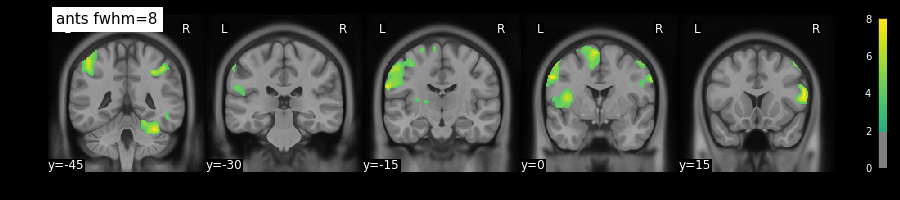

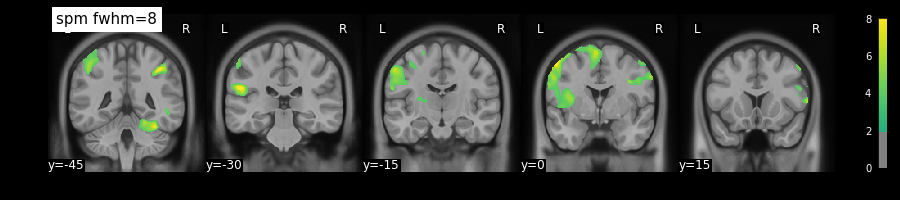

In [12]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm4/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm4/spmT_0001_thr.nii', title='spm fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm8/spmT_0001_thr.nii', title='ants fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm8/spmT_0001_thr.nii', title='spm fwhm=8',
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

The results are more or less what you would expect: The peaks are more or less at the same places for the two normalization approaches and a wider smoothing has the effect of bigger clusters, while losing the sensitivity for smaller clusters.

Now, let's see other contrast -- **Finger > others**. Since we removed left handed subjects, the activation is seen on the left part of the brain.

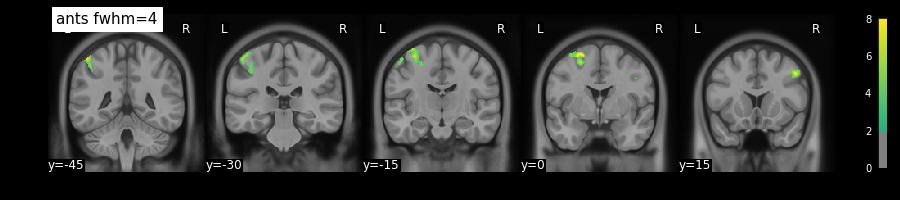

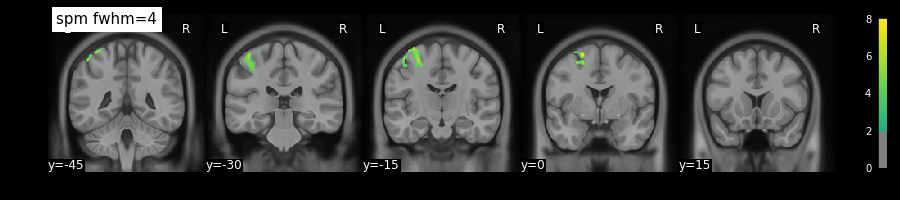

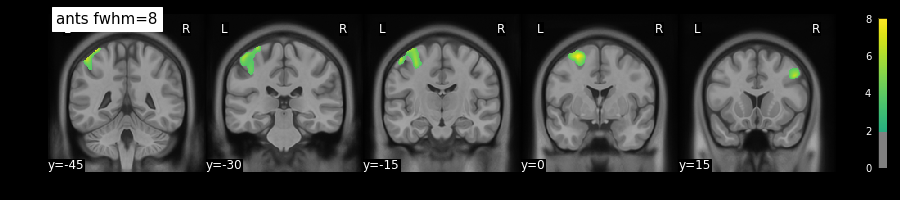

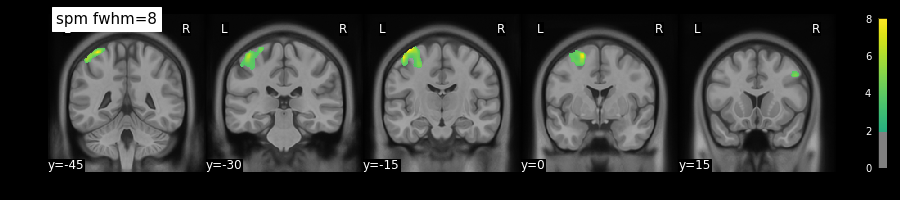

In [13]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001_thr.nii', title='spm fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm8/spmT_0001_thr.nii', title='ants fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm8/spmT_0001_thr.nii', title='spm fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

Now, let's see the results using the glass brain plotting method.

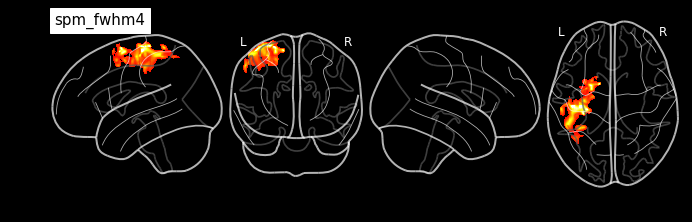

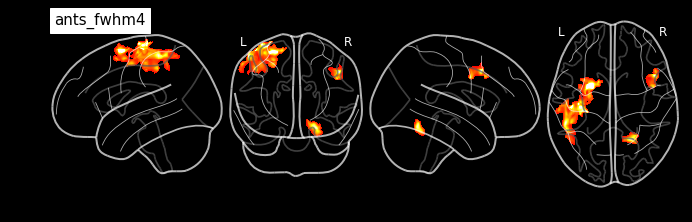

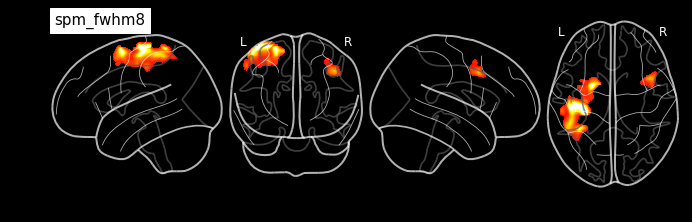

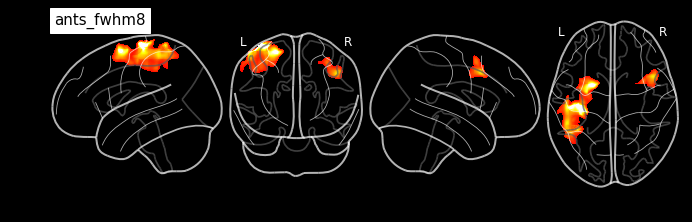

In [14]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001_thr.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm4')

plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001_thr.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm4')

plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm8/spmT_0001_thr.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm8')

plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm8/spmT_0001_thr.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm8')